# Temperature motor predictor
The goal of this project is to design and test a motor temperature predictor capable of estimating the temperatures of critical magneto-electric components, such as the permanent magnets (PM) and the stator windings, without relying on direct sensors.
Direct measurement of these temperatures is often impractical in real-world applications due to limitations in sensor placement, cost, and reliability. However, accurate thermal information is crucial for safe operation, performance optimization, and lifetime estimation of electric machines.
To overcome this challenge, the predictor is trained using workbench test data collected from the motor under controlled conditions. In this setup, high-accuracy sensors are used to measure internal temperatures while the motor undergoes a wide range of test cycles that reflect diverse operating scenarios (varying torque, speed, currents, voltages, and cooling conditions).
The project follows a data-driven approach where these experimental datasets serve as the foundation for building and validating machine learning models. By learning the complex relationships between measurable external variables (e.g., torque, motor speed, voltages, currents, coolant temperature) and the internal temperatures of critical components, the predictor can provide reliable estimates during real operation—where only external signals are available.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
ds = pd.read_csv("measures_v2.csv")
ds_down = ds.iloc[::100]   # take every 50th sample

# Motor Thermal Characteristics Dataset

"This dataset contains sensor recordings from a permanent magnet synchronous motor (PMSM) undergoing test bench measurements, collected by the LEA department at Paderborn University. It includes 185 hours of data, expanded from an initial 138 hours, with all data now deanonymised. The motor is a prototype model from a German OEM. The data was gathered by exciting the motor with hand-designed driving cycles that simulate real-world conditions by denoting reference motor speed and torque. This dataset is particularly valuable for developing predictive models for rotor temperature and torque, as these are features that are often difficult and costly to measure reliably in commercial vehicles."

Source: https://www.opendatabay.com/data/consumer/ab235a62-f7ab-4fd5-ac24-f42945583f88

### Dataset Dimensions and Columns Description
The dataset consists of 13 columns sampled at a frequency of 2 Hz.

| Column           | Description                                                                                                  | Units |
| ---------------- | ------------------------------------------------------------------------------------------------------------ | ----- |
| `u_q`            | Voltage q-component measurement in dq-coordinates                                                            | Volts |
| `coolant`        | Coolant temperature                                                                                          | °C    |
| `stator_winding` | Stator winding temperature, measured using thermocouples                                                     | °C    |
| `u_d`            | Voltage d-component measurement in dq-coordinates                                                            | Volts |
| `stator_tooth`   | Stator tooth temperature, measured using thermocouples                                                       | °C    |
| `motor_speed`    | Motor speed                                                                                                  | RPM   |
| `i_d`            | Current d-component measurement in dq-coordinates                                                            | Amps  |
| `i_q`            | Current q-component measurement in dq-coordinates                                                            | Amps  |
| `pm`             | Permanent magnet temperature, measured with thermocouples and transmitted wirelessly via a thermography unit | °C    |
| `stator_yoke`    | Stator yoke temperature, measured using thermocouples                                                        | °C    |
| `ambient`        | Ambient temperature                                                                                          | °C    |
| `torque`         | Motor torque                                                                                                 | Nm    |
| `profile_id`     | Integer identifier for each distinct measurement session                                                     | -     |

## Dataset overview analysis

In this section, a general overview of the available dataset is presented, followed by an initial exploratory analysis of the variables. The objective is to highlight the main characteristics of the collected signals and to investigate possible correlations among them. Understanding these relationships is a crucial preliminary step, as it provides insights into how operating conditions such as torque, speed, voltages, currents, and cooling parameters may influence the thermal behavior of the motor.

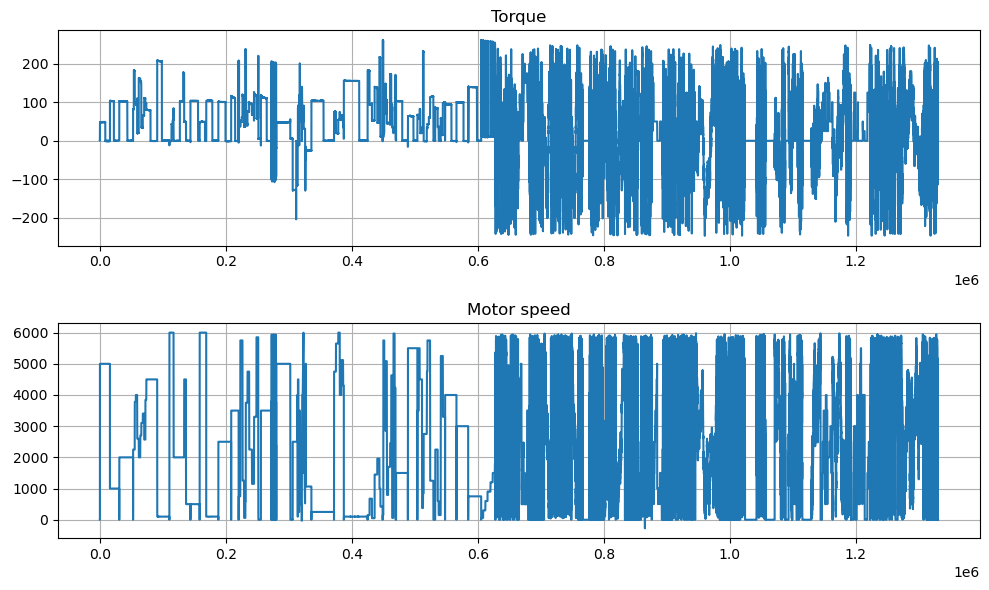

In [68]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1,figsize=(12,5))

ax1.plot(ds["torque"],label="Torque [Nm]")
ax1.title.set_text("Torque")
ax1.grid(True)
ax2.plot(ds["motor_speed"],label="Motor speed [rpm]")
ax2.title.set_text("Motor speed")
ax2.grid(True)
plt.tight_layout() 


C:\Users\stefa\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\stefa\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


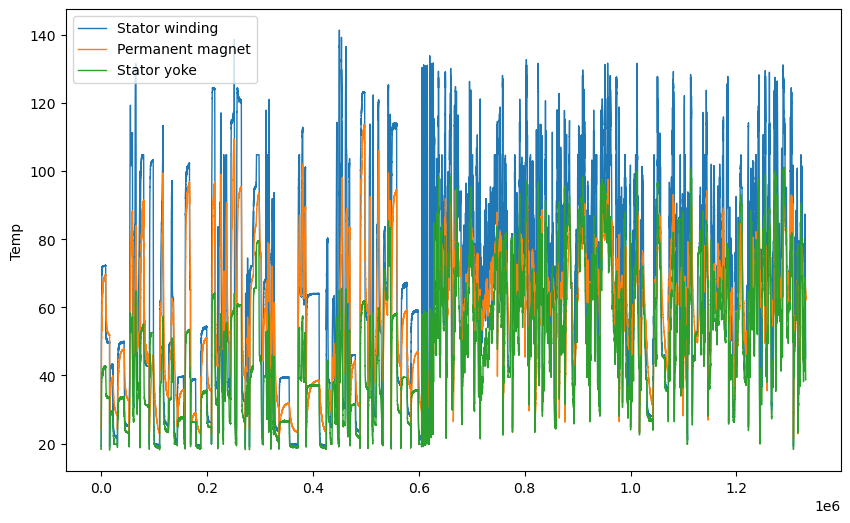

In [67]:
tempFig, ax= plt.subplots(figsize=(12,5))
ax.plot(ds["stator_winding"] ,lw=1)
ax.plot(ds["pm"],lw=1)
ax.plot(ds["stator_yoke"],lw=1)
plt.ylabel("Temp")
plt.legend(['Stator winding',"Permanent magnet","Stator yoke"])


As clearly visible, the stator winding emerges as the most critical component in terms of higher temperature, followed by the permanent magnets. For this reason, the subsequent analysis is focused on the estimation of these two values, as they represent the key thermal indicators for assessing motor safety and performance.

### Influence of Torque and Speed on Motor Temperature

The thermal behavior of electric motors is strongly influenced by their operating conditions, with torque and speed being the primary drivers of power losses and heat generation. Higher torque levels increase copper losses due to elevated currents, while higher speeds contribute to iron and switching losses, both of which directly affect the temperature rise of critical components such as the stator windings and permanent magnets. Understanding the relationship between torque, speed, and resulting thermal states is essential for developing accurate temperature prediction models and ensuring safe and efficient operation of the motor.

Text(0.5, 1.0, 'PM temperature over torque demand')

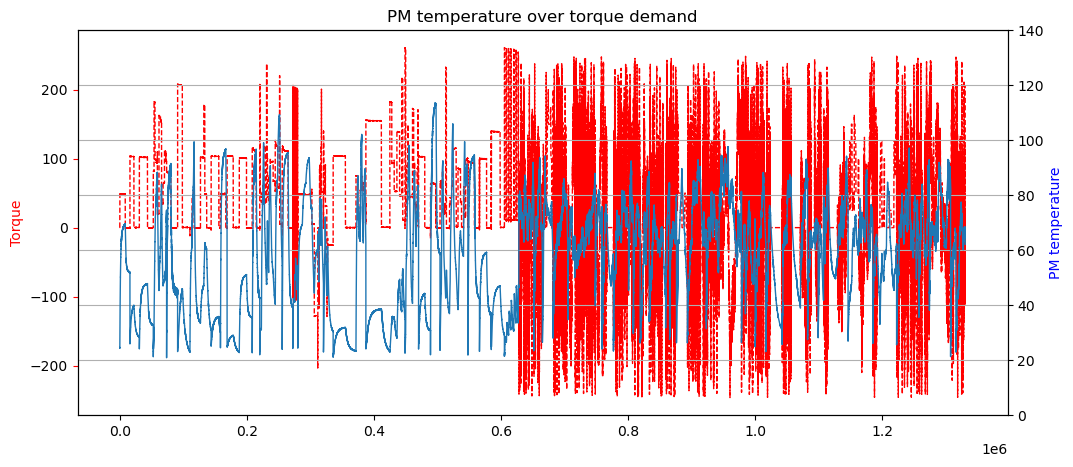

In [22]:
TorqueVSTemp, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(ds["torque"],color="red",lw=1,linestyle= "--",label="Torque")
ax1.set(ylabel="Torque")
ax1.yaxis.label.set_color("red")
ax1.tick_params(axis="y", color="red")

ax2 = ax1.twinx() 
ax2.plot(ds["pm"],lw=1,label="PM temperature")
ax2.yaxis.label.set_color("blue")
ax2.set(ylabel="PM temperature")
ax2.set_ylim(0,140)

plt.grid()
plt.title("PM temperature over torque demand")


Text(0.5, 1.0, 'Stator winding temperature over torque demand')

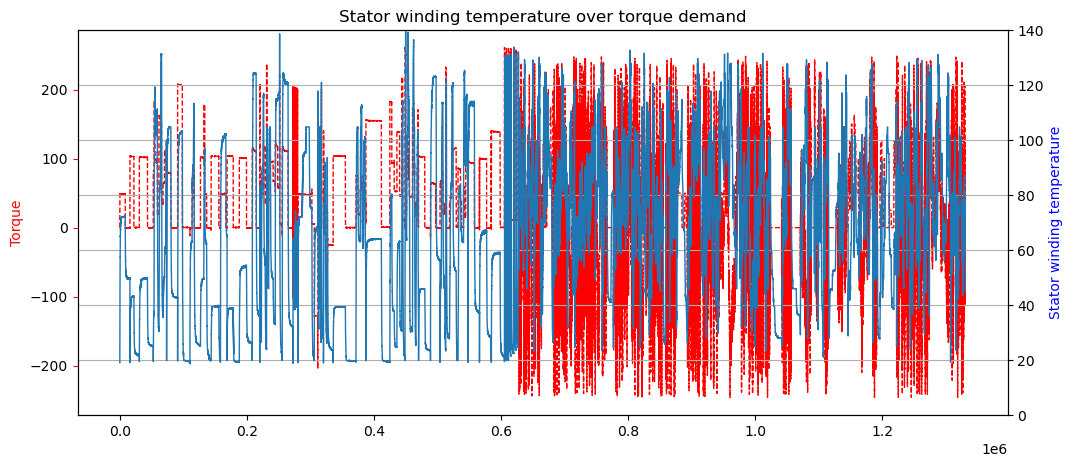

In [21]:
TorqueVSTemp, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(ds["torque"],color="red",lw=1,linestyle= "--",label="Torque")
ax1.set(ylabel="Torque")
ax1.yaxis.label.set_color("red")
ax1.tick_params(axis="y", color="red")

ax2 = ax1.twinx() 
ax2.plot(ds["stator_winding"],lw=1,label="Stator winding temperature")
ax2.yaxis.label.set_color("blue")
ax2.set_ylim(0,140)
ax2.set(ylabel="Stator winding temperature")

plt.grid()
plt.title("Stator winding temperature over torque demand")

Text(0.5, 1.0, 'PM temperature over motor speed')

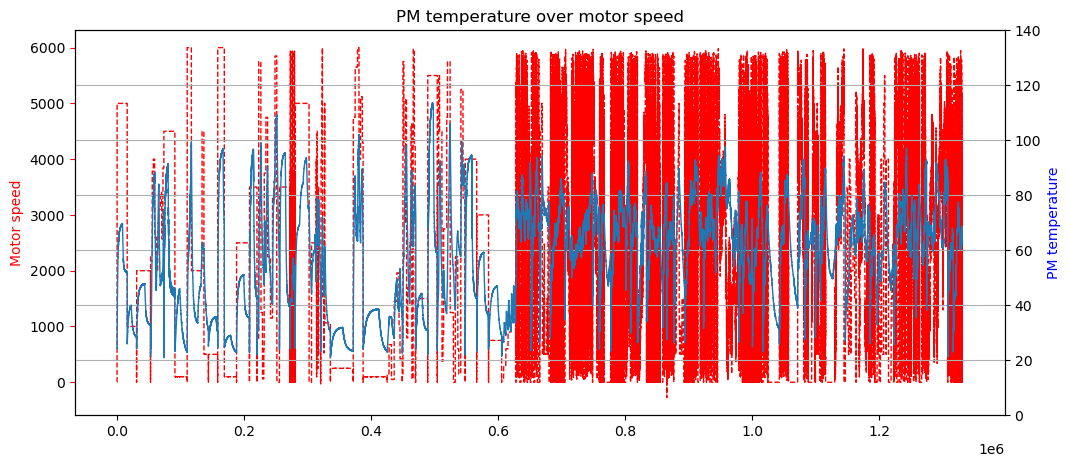

In [23]:
TorqueVSTemp, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(ds["motor_speed"],color="red",lw=1,linestyle= "--",label="Motor speed")
ax1.set(ylabel="Motor speed")
ax1.yaxis.label.set_color("red")
ax1.tick_params(axis="y", color="red")

ax2 = ax1.twinx() 
ax2.plot(ds["pm"],lw=1,label="PM temperature")
ax2.yaxis.label.set_color("blue")
ax2.set_ylim(0,140)
ax2.set(ylabel="PM temperature")

plt.grid()
plt.title("PM temperature over motor speed")

Text(0.5, 1.0, 'Stator winding temperature over motor speed')

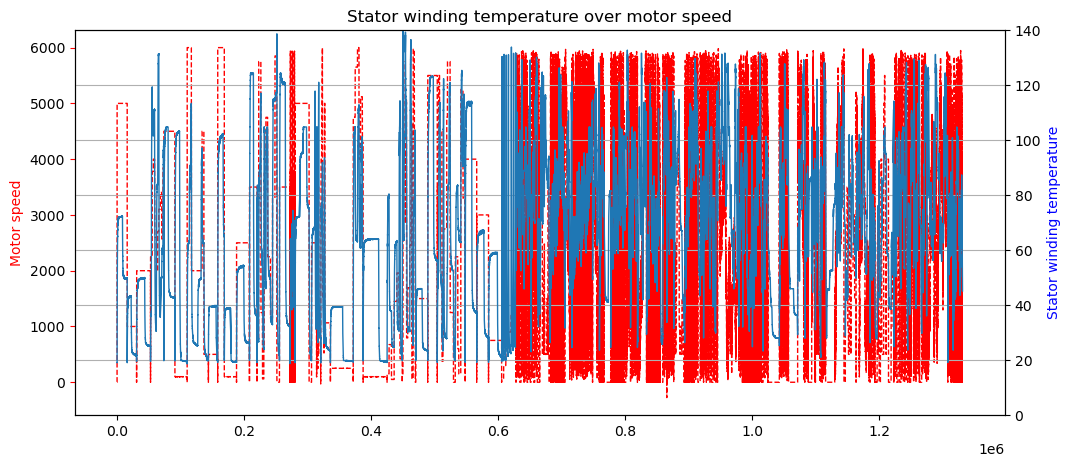

In [24]:
TorqueVSTemp, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(ds["motor_speed"],color="red",lw=1,linestyle= "--",label="Motor speed")
ax1.set(ylabel="Motor speed")
ax1.yaxis.label.set_color("red")
ax1.tick_params(axis="y", color="red")

ax2 = ax1.twinx() 
ax2.plot(ds["stator_winding"],lw=1,label="Stator winding temperature")
ax2.yaxis.label.set_color("blue")
ax2.set_ylim(0,140)
ax2.set(ylabel="Stator winding temperature")

plt.grid()
plt.title("Stator winding temperature over motor speed")

The operating map illustrates the distribution of motor operating points in terms of torque and speed, providing insights into how the machine is typically used across different load conditions. By overlaying temperature as a scatter metric on the torque–speed plane, the map highlights how thermal stress correlates with operating conditions.

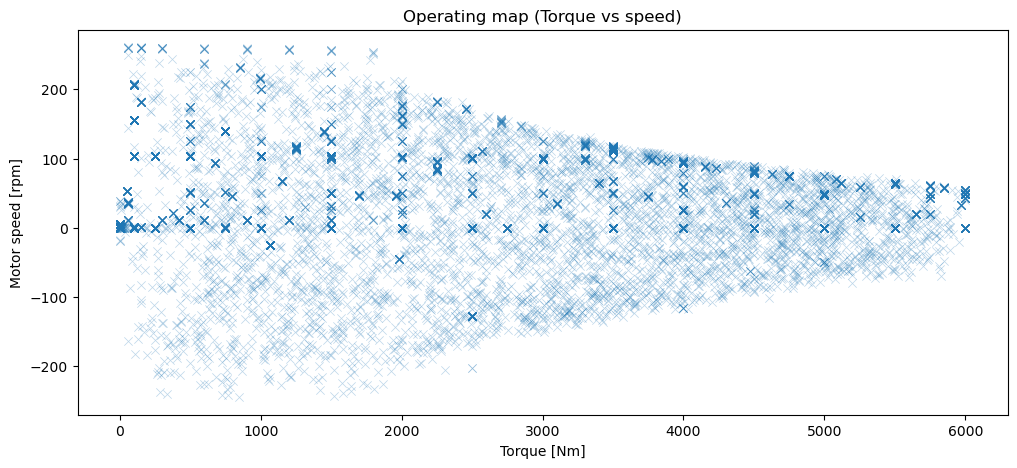

In [27]:
plt.figure(figsize=(12,5))
plt.scatter(ds_down["motor_speed"], ds_down["torque"], alpha=0.3,marker="x",linewidth=0.5)
plt.xlabel("Torque [Nm]")
plt.ylabel("Motor speed [rpm]")
plt.title("Operating map (Torque vs speed)")
plt.show()

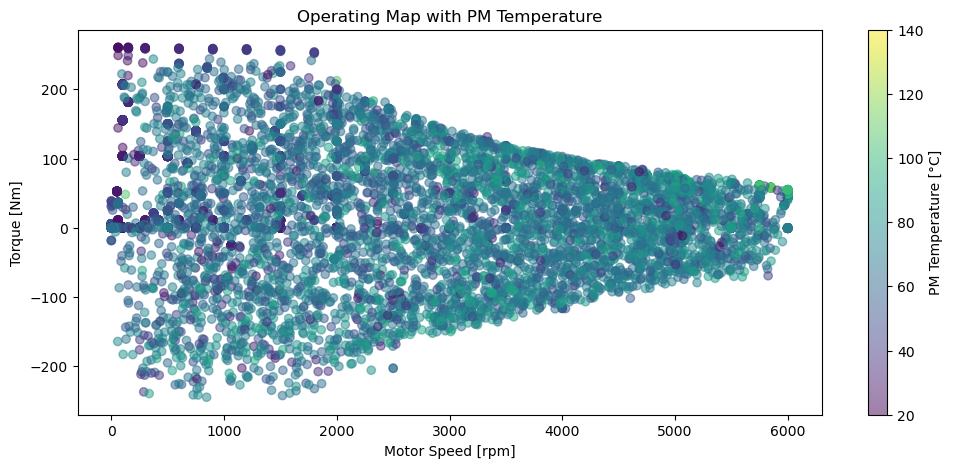

In [28]:
plt.figure(figsize=(12,5))
plt.scatter(ds_down["motor_speed"], ds_down["torque"], c=ds_down["pm"], cmap="viridis", alpha=0.5,vmin = 20,vmax=140)
plt.colorbar(label="PM Temperature [°C]")
plt.xlabel("Motor Speed [rpm]")
plt.ylabel("Torque [Nm]")
plt.title("Operating Map with PM Temperature")
plt.show()

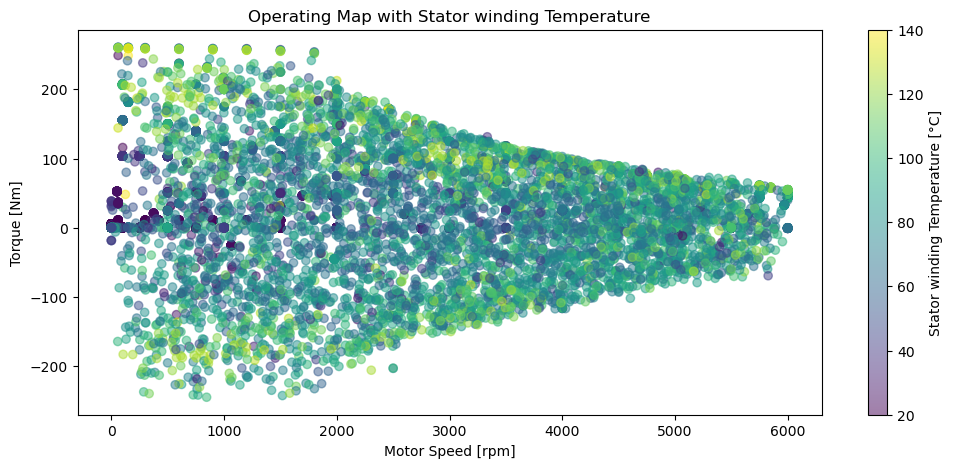

In [29]:
plt.figure(figsize=(12,5))
plt.scatter(ds_down["motor_speed"], ds_down["torque"], c=ds_down["stator_winding"], cmap="viridis", alpha=0.5,vmin = 20,vmax=140)
plt.colorbar(label="Stator winding Temperature [°C]")
plt.xlabel("Motor Speed [rpm]")
plt.ylabel("Torque [Nm]")
plt.title("Operating Map with Stator winding Temperature")
plt.show()

### Correlation analysis
A correlation coefficient is a statistical measure (represented by 'r') that quantifies the strength and direction of a linear relationship between two variables, ranging from -1 to +1. A value of +1 indicates a perfect positive correlation (as one variable increases, the other increases proportionally), while -1 signifies a perfect negative correlation (as one increases, the other decreases). A value of 0 indicates no linear relationship. 

r = [ n * Σ(x * y) - (Σx) * (Σy) ] / sqrt( [ n * Σ(x²) - (Σx)² ] * [ n * Σ(y²) - (Σy)² ] )

Source: https://www.jmp.com/en/statistics-knowledge-portal/what-is-correlation/correlation-coefficient

In [32]:
# Compute correlation coefficients
corr_torque_pm = ds["torque"].corr(ds["pm"])
corr_speed_pm  = ds["motor_speed"].corr(ds["pm"])

corr_torque_stator_winding = ds["torque"].corr(ds["stator_winding"])
corr_speed_stator_winding  = ds["motor_speed"].corr(ds["stator_winding"])

corr_torque_stator_yoke = ds["torque"].corr(ds["stator_yoke"])
corr_speed_stator_yoke  = ds["motor_speed"].corr(ds["stator_yoke"])

corr_data = {
    "Torque vs Temp": [
        corr_torque_pm, 
        corr_torque_stator_winding, 
        corr_torque_stator_yoke
    ],
    "Speed vs Temp": [
        corr_speed_pm, 
        corr_speed_stator_winding, 
        corr_speed_stator_yoke
    ]
}

corr_table = pd.DataFrame(
    corr_data,
    index=["Permanent Magnet", "Stator Winding", "Stator Yoke"]
)

print("Correlation analysis:")
print(corr_table)

Correlation analysis:
                  Torque vs Temp  Speed vs Temp
Permanent Magnet       -0.117138       0.458947
Stator Winding          0.095510       0.432034
Stator Yoke            -0.117118       0.255790


The correlation analysis highlights that motor speed has a consistently stronger influence on all monitored temperatures compared to torque. This suggests that thermal stress in the motor is primarily linked to rotational speed, likely due to higher iron and frictional losses at elevated rpm. In contrast, torque shows only weak or even negative correlations, indicating that load has a much smaller effect on the thermal dynamics under the tested conditions.

### Consideration:
At higher rotational speeds, the frequency of the magnetic field variations increases, leading to significant iron losses, which comprise:
- Eddy Current Losses: Induced circulating currents within the motor's iron core generate heat. These losses are proportional to the square of the frequency and the square of the magnetic flux density.
- Hysteresis Losses: Result from the lag between the magnetic field and the magnetization of the iron core. At higher speeds, the rapid reversal of the magnetic field exacerbates these losses.

At elevated speeds, friction and windage losses become more significant due to:
- Air Resistance: The rotor's high speed increases the air resistance within the motor, leading to higher windage losses. These losses are proportional to the cube of the rotational speed.
- Bearing Friction: The bearings experience increased friction at higher speeds, contributing to additional heat generation.

# Temperature predictor design

The goal of this project is to build a data-driven predictor that estimates motor temperatures based on measurable operating parameters. The predictor aims to reproduce otherwise unmeasurable quantities such as the permanent magnet and stator winding temperatures.

The final objective is to design and evaluate a machine learning model capable of predicting the temperatures using input features such as torque, motor speed, dq-currents, ambient and coolant temperature.

Such a model can support:
- Real-time monitoring of motor health without invasive sensors,
- Optimization of control strategies based on thermal limits,
- Support for thermal management system design to enhance efficiency and lifetime.

#### Workflow

According to the literature reviewed (https://young-wombat-ba9.notion.site/Thermal-Analysis-and-Simulation-for-Electric-Motors-2865c07cd00380eab2f0c9f414ca1273?source=copy_link), three different thermal prediction approaches are implemented and compared. First, a physics-based predictor using a lumped-parameter (RC) thermal model is developed and validated. Next, a black-box model, trained directly on experimental data, is introduced to capture nonlinear relationships between operating variables and temperature evolution. Finally, a hybrid approach, referred to as a Thermal Neural Network (TNN), combines the physical RC model with a neural correction layer to improve accuracy while maintaining interpretability. The performance of these three models is evaluated and compared in terms of prediction accuracy and computational efficiency, in order to determine the most suitable method for real-time motor thermal estimation.

#### Metrics
###### R² (Coefficient of Determination)
How much of the variance in the target variable (temperature, in your case) is explained by the model.

Interpretation:
- R² = 1 → Perfect prediction.
- R² = 0 → Model is no better than predicting the mean of the data.
- R² < 0 → Model is worse than the mean (the errors are larger than just guessing the average).

###### RMSE (Root Mean Squared Error)
The average magnitude of prediction errors in the same unit as the target (°C in your case).

Interpretation:
- A smaller RMSE means predictions are closer to the actual values.
- Since it’s in °C, you can compare it to the typical operating range. For example, if temperatures range 40–120 °C, an RMSE of 20 °C is quite poor (errors are ~25% of the full range)

## Linear regression

As an initial step, a linear regression model was implemented to establish a baseline for comparison with more complex approaches. Although conceptually simple, this model assumes a linear relationship between input variables (such as torque, speed, and electrical currents) and the resulting component temperatures.

However, thermal behavior in electric traction motors is inherently nonlinear. Heat generation scales with the square of the current, cooling efficiency depends on flow conditions and motor speed, and the thermal coupling between stator, magnets, and coolant introduces nonlinear interactions. Moreover, thermal inertia creates a strong time dependency that a static linear model cannot capture.

Therefore, while linear regression serves as a useful benchmark to validate the workflow and quantify the minimal achievable accuracy, it lacks physical consistency and predictive capability for dynamic operating conditions. This motivates the transition toward nonlinear and physics-informed models such as Random Forests, Gradient Boosting, and hybrid Thermal Neural Networks.

In [3]:
from sklearn.linear_model import LinearRegression

## Problem definition
# target
tg = ds[["stator_winding","pm"]]

# input
X = ds[["torque","motor_speed","u_q","u_d","i_q","i_d","coolant","ambient"]]

sklearn.model_selection.train_test_split(): Split arrays or matrices into random train and test subsets.
Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Scikit-Learn: powerful Python library, extensively used for machine learning tasks. It provides simple and efficient tools for data mining and data analysis.

The fit() method in Scikit-Learn is used to train a machine learning model. Training a model involves feeding it with data so it can learn the underlying patterns. This method adjusts the parameters of the model based on the provided data.

Syntax:

model.fit(X, y)

X: The feature matrix, where each row represents a sample and each column represents a feature.
y: The target vector, containing the labels or target values corresponding to the samples in X.

R²: 0.3563421180531533
RMSE: 13.958882215306817


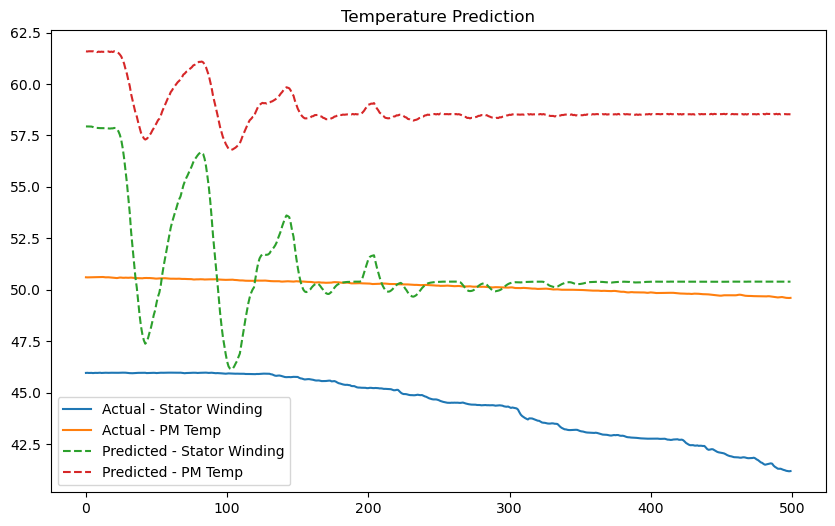

In [4]:
## Data preparation
X_train, X_test, tg_train, tg_test = train_test_split(X, tg, test_size=0.2, random_state=42, shuffle=False)

## Baseline model

model = LinearRegression()
model.fit(X_train, tg_train)

tg_pred = model.predict(X_test)

## Model evaluation
print("R²:", r2_score(tg_test, tg_pred))
print("RMSE:", np.sqrt(mean_squared_error(tg_test, tg_pred)))

## Visualize prediction

plt.figure(figsize=(10,6))

# Plot Actual values
plt.plot(tg_test.values[:500, 0], label="Actual - Stator Winding")
plt.plot(tg_test.values[:500, 1], label="Actual - PM Temp")

# Plot Predicted values
plt.plot(tg_pred[:500, 0], "--", label="Predicted - Stator Winding")
plt.plot(tg_pred[:500, 1], "--", label="Predicted - PM Temp")

plt.legend()
plt.title("Temperature Prediction")
plt.show()

### Consideration: 
The results obtained from the linear regression model clearly underline its inadequacy for capturing the thermal behavior of electric machines. The model failed to represent the inherent nonlinearities and transient effects governing temperature evolution. Linear regression can serve as a baseline reference to validate the data pipeline and assess the performance gap with more advanced models. However, for accurate and physically consistent temperature prediction, nonlinear or hybrid approaches are essential to capture both the static and dynamic aspects of motor thermal behavior.

## Lumped-Parameter Thermal Networks

Lumped-parameter thermal networks are simplified thermal models used to describe heat transfer dynamics in electrical machines and other systems.
Instead of solving complex 3D heat conduction equations, the system is represented as a network of thermal resistances and capacitances — analogous to electrical circuits.
Each “node” corresponds to a region of the machine (e.g., stator, rotor, housing) assumed to have a uniform temperature, while the resistances model conductive or convective heat paths between them and to the environment.


### 1 node RC model
The simplest lumped model is the **single-node RC model**, which represents the entire thermal mass of a component with one capacitance \( C \) (thermal inertia) and one resistance \( R \) (heat dissipation path).

The thermal dynamics are governed by:

C dt/dT =Ploss − (T−Tcool)/R

C:\Users\stefa\AppData\Local\Temp\ipykernel_15680\2237027645.py:23: RuntimeWarning: overflow encountered in exp
  R, C = np.exp(log_params)
C:\Users\stefa\AppData\Local\Temp\ipykernel_15680\2237027645.py:23: RuntimeWarning: overflow encountered in exp
  R, C = np.exp(log_params)


Component  R_opt [°C/W]  C_opt [J/°C]   RMSE [°C]
0    Stator Winding          0.05       15000.0  182.350227
1  Permanent Magnet          0.20         800.0  859.212724

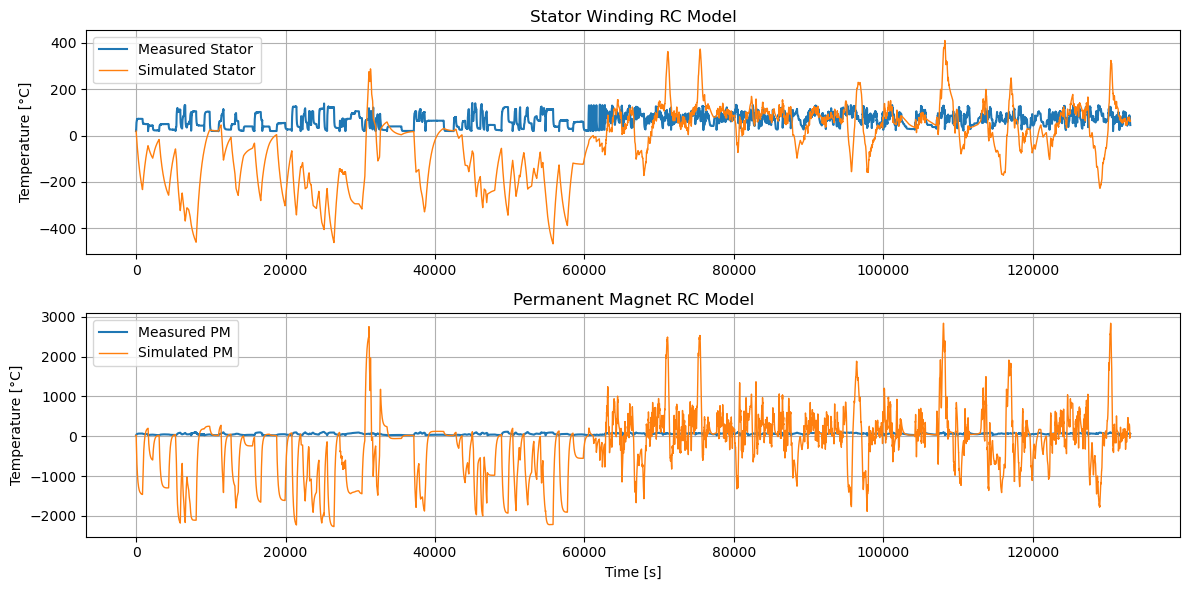

In [6]:
from scipy.optimize import minimize

sampling_time = 0.1 
ds_fit = ds.iloc[::10].reset_index(drop=True) 
dt = sampling_time * 10.0                       

P_mech = ds_fit["torque"] * (ds_fit["motor_speed"] * 2*np.pi/60.0)
P_elec = ds_fit["u_d"]*ds_fit["i_d"] + ds_fit["u_q"]*ds_fit["i_q"]
P_loss = P_elec - P_mech
T_cool = ds_fit["coolant"].values
n = len(ds_fit)

def simulate_euler(R, C, P_loss, T_cool, T_init):
    T = np.zeros(len(P_loss))
    T[0] = T_init
    for i in range(1, len(P_loss)):
        dTdt = (P_loss.iloc[i] - (T[i-1] - T_cool[i-1]) / R) / C
        T[i] = T[i-1] + dTdt * dt
    return T

# Cost function 
def cost(log_params, T_meas):
    R, C = np.exp(log_params)
    if R <= 0 or C <= 0:
        return 1e9
    T_sim = simulate_euler(R, C, P_loss, T_cool, T_meas[0])
    return np.mean((T_sim - T_meas)**2)

# STATOR WINDING
T_meas_stator = ds_fit["stator_winding"].values
initial_guess_stator = [0.05, 15000]
bounds_stator = [(0.01, 0.2), (2000, 50000)]

res_stator = minimize(cost, initial_guess_stator, args=(T_meas_stator,),
                      bounds=bounds_stator, options={'maxiter':200, 'disp':True})

R_stat, C_stat = res_stator.x
T_sim_stator = simulate_euler(R_stat, C_stat, P_loss, T_cool, T_meas_stator[0])
rmse_stator = np.sqrt(mean_squared_error(T_meas_stator, T_sim_stator))

# PERMANENT MAGNET
T_meas_pm = ds_fit["pm"].values
initial_guess_pm = [0.2, 800]
bounds_pm = [(0.05, 1.0), (200, 5000)]

res_pm = minimize(cost, initial_guess_pm, args=(T_meas_pm,),
                  bounds=bounds_pm, options={'maxiter':200, 'disp':True})

R_pm, C_pm = res_pm.x
T_sim_pm = simulate_euler(R_pm, C_pm, P_loss, T_cool, T_meas_pm[0])
rmse_pm = np.sqrt(mean_squared_error(T_meas_pm, T_sim_pm))

results = pd.DataFrame({
    "Component": ["Stator Winding", "Permanent Magnet"],
    "R_opt [°C/W]": [R_stat, R_pm],
    "C_opt [J/°C]": [C_stat, C_pm],
    "RMSE [°C]": [rmse_stator, rmse_pm]
})
display(results)

t = np.arange(n) * dt
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(t, T_meas_stator, label="Measured Stator", lw=1.5)
plt.plot(t, T_sim_stator, label="Simulated Stator", lw=1)
plt.ylabel("Temperature [°C]")
plt.title("Stator Winding RC Model")
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(t, T_meas_pm, label="Measured PM", lw=1.5)
plt.plot(t, T_sim_pm, label="Simulated PM", lw=1)
plt.xlabel("Time [s]")
plt.ylabel("Temperature [°C]")
plt.title("Permanent Magnet RC Model")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### 2-node RC model

A single-node (1-RC) thermal model assumes that the entire motor can be represented by a single uniform temperature, governed by one thermal resistance and one thermal capacitance. While this simplification makes the model computationally light, it neglects the internal thermal gradients that exist between different motor components. In practice, the permanent magnets (PM) and the stator winding experience distinct heating and cooling dynamics — copper losses dominate in the stator windings, while eddy current and hysteresis losses heat the magnets more slowly. Moreover, the thermal path from the PMs to the coolant passes through multiple layers of materials with different conductivities, causing measurable delays and differences in temperature response.

The 1-node model therefore fails to capture these spatial temperature differences and time lags, leading to inaccurate prediction of local hot spots and transient behaviors — especially in high-performance traction motors where temperature gradients can exceed tens of degrees Celsius.
A two-node model (2-RC network), by contrast, introduces a more realistic representation: one node for the PMs and one for the stator, connected by a thermal resistance. This allows the model to simulate internal heat exchanges between components and better reflect the physical structure of the motor.

Physical structure:

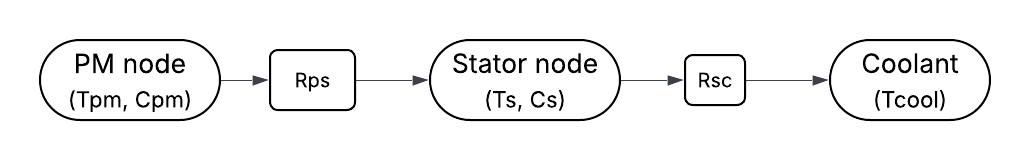

In [7]:
from scipy.optimize import minimize
from sklearn.linear_model import Ridge

# --- Dati di ingresso ---
sampling_time = 0.1
ds_fit = ds.iloc[::10].reset_index(drop=True)
dt = sampling_time * 10.0

P_mech = ds_fit["torque"] * (ds_fit["motor_speed"] * 2*np.pi/60.0)
P_elec = ds_fit["u_d"]*ds_fit["i_d"] + ds_fit["u_q"]*ds_fit["i_q"]
P_loss = (P_elec - P_mech).clip(lower=0) 
T_cool = ds_fit["coolant"].values
T_meas_stator = ds_fit["stator_winding"].values
T_meas_pm = ds_fit["pm"].values
n = len(ds_fit)

#### Loss correction regression
A common source of error in RC-based thermal models lies in the estimation of the heat generation term P_loss.  
In practice, this quantity may not perfectly represent the actual thermal power dissipated in the motor, as it can neglect effects such as core losses, inverter losses, or nonlinear dependencies on speed and current.  
To improve model accuracy with minimal added complexity, a simple regression model—such as a linear or Ridge regression—can be fitted to predict the effective (P_loss) from measurable quantities like omega^2, i_q,  P_elec.  
This data-driven correction refines the thermal input to the RC simulator, often reducing systematic biases and improving temperature prediction performance without altering the underlying physical structure.


Component  R_opt [°C/W]  C_opt [J/°C]  RMSE [°C]
0  Permanent Magnet      0.200000  20000.000000  35.051474
1    Stator Winding      0.009163  66394.548939  26.587020

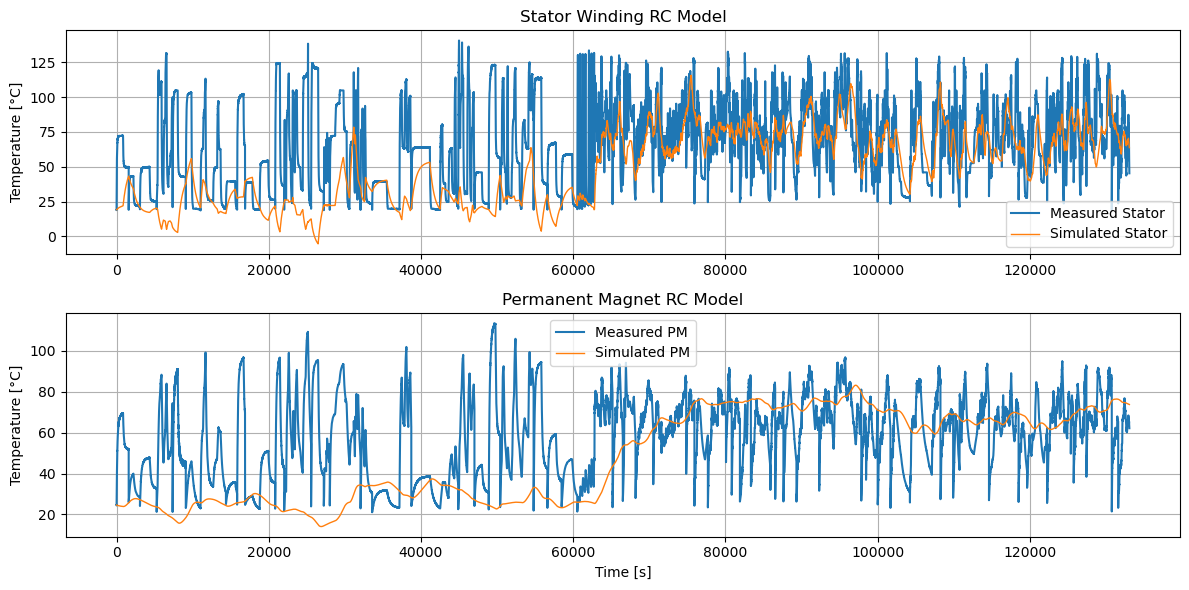

In [8]:
X = np.vstack([
    P_elec.values,
    (ds_fit["motor_speed"]*2*np.pi/60.0)**2,
    np.abs(ds_fit["i_q"]).values,
    np.ones(len(ds_fit))
]).T
y = P_loss.values
lr = Ridge(alpha=1.0).fit(X, y)
P_heat = lr.predict(X)

# --- Simulatore RC 2 nodi ---
def simulate_2RC(R_ps, R_sc, C_pm, C_s):
    T_pm = np.zeros(n)
    T_s = np.zeros(n)
    T_pm[0] = T_meas_pm[0]
    T_s[0] = T_meas_stator[0]
    
    for i in range(1, n):
        dTpm_dt = (T_s[i-1] - T_pm[i-1]) / (R_ps * C_pm)
        dTs_dt  = (P_heat[i] - (T_s[i-1] - T_cool[i-1]) / R_sc - (T_s[i-1] - T_pm[i-1]) / R_ps) / C_s
        T_pm[i] = T_pm[i-1] + dTpm_dt * dt
        T_s[i]  = T_s[i-1] + dTs_dt * dt
    return T_pm, T_s

def cost(log_params):
    """
    Cost function for 2-node RC thermal model using log-parameter optimization.
    
    log_params : array-like
        [log(R_ps), log(R_sc), log(C_pm), log(C_s)]
    
    Returns
    -------
    cost_value : float
        Sum of mean squared errors for PM and stator winding temperatures.
    """
    # Convert from log-space to physical parameters
    R_ps, R_sc, C_pm, C_s = np.exp(log_params)

    # Simulate temperatures
    T_pm_sim, T_s_sim = simulate_2RC(R_ps, R_sc, C_pm, C_s)

    # Compute MSE for each component
    err_pm = np.mean((T_pm_sim - T_meas_pm)**2)
    err_s  = np.mean((T_s_sim - T_meas_stator)**2)

    # Total cost (sum of both MSEs)
    return err_pm + err_s


# --- Valori iniziali e bounds realistici ---
initial_guess = [0.05, 0.01, 5000, 50000]  # [R_ps, R_sc, C_pm, C_s]
bounds = [(0.01, 0.2), (0.005, 0.05), (1000, 20000), (10000, 80000)]

log_initial_guess = np.log(initial_guess)
log_bounds = [(np.log(lo), np.log(hi)) for lo, hi in bounds]

# --- Ottimizzazione ---
res = minimize(cost,log_initial_guess, bounds=log_bounds, options={'maxiter': 200, 'disp': True})
R_ps, R_sc, C_pm, C_s = np.exp(res.x)

np.savez("thermal_params.npz", R_ps=R_ps, R_sc=R_sc, C_pm=C_pm, C_s=C_s)


# --- Simulazione finale ---
T_pm_sim, T_s_sim = simulate_2RC(R_ps, R_sc, C_pm, C_s)

# --- Valutazione ---
rmse_pm = np.sqrt(np.mean((T_pm_sim - T_meas_pm)**2))
rmse_s = np.sqrt(np.mean((T_s_sim - T_meas_stator)**2))

# --- Risultati ---
import pandas as pd
results = pd.DataFrame({
    "Component": ["Permanent Magnet", "Stator Winding"],
    "R_opt [°C/W]": [R_ps, R_sc],
    "C_opt [J/°C]": [C_pm, C_s],
    "RMSE [°C]": [rmse_s, rmse_pm]
})

display(results)

# --- Plot confronto ---
t = np.arange(n) * dt
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(t, T_meas_stator, label="Measured Stator", lw=1.5)
plt.plot(t, T_s_sim, label="Simulated Stator", lw=1)
plt.ylabel("Temperature [°C]")
plt.title("Stator Winding RC Model")
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(t, T_meas_pm, label="Measured PM", lw=1.5)
plt.plot(t, T_pm_sim, label="Simulated PM", lw=1)
plt.xlabel("Time [s]")
plt.ylabel("Temperature [°C]")
plt.title("Permanent Magnet RC Model")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Considerations

The 2-node RC thermal model developed provides a physically meaningful yet simplified representation of the heat transfer mechanisms within the motor. Its formulation relies on several key assumptions: isothermal nodes, constant thermal parameters, a single lumped heat source, and a fixed coolant boundary condition. These simplifications enable an efficient and interpretable model but inevitably limit its accuracy in capturing nonlinear or spatially distributed effects. Consequently, discrepancies between simulated and measured temperatures may arise, even though the model is theoretically valid. Such errors are often due to uncertainties in loss estimation, unmodelled dynamics (e.g., coolant inertia or temperature-dependent convection), or parameter identifiability issues within the available dataset. Despite these limitations, the RC model remains a valuable foundation for understanding the system’s thermal behavior and serves as a robust baseline for more advanced approaches, such as data-driven or hybrid thermal neural networks.

## Black-box model: data driven model by machine learning

### Random Forest regression

Random Forest regression is chosen as the next step after testing linear models. Unlike linear regression, which assumes a straight-line relationship between inputs and outputs, Random Forests can naturally capture nonlinear dependencies and complex interactions between features such as torque, speed, and temperatures. While individual decision trees are often unstable and prone to overfitting, Random Forests overcome this by averaging the predictions of many trees, resulting in a more robust and accurate model.

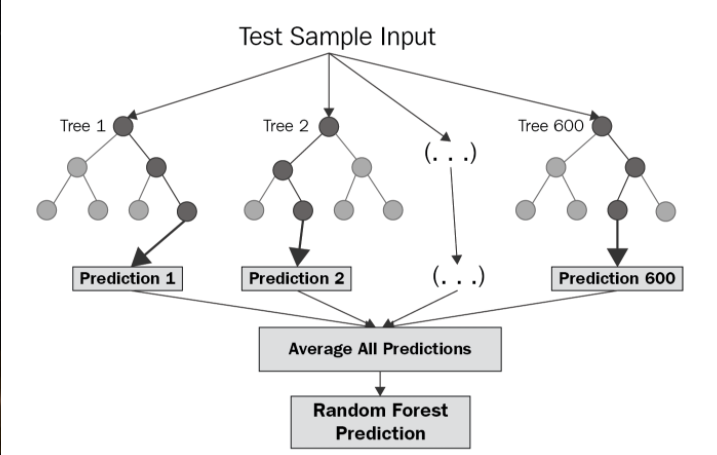

| Model                | Pro                                                              | Cons                                                             | Motor Temp Prediction |
|-----------------------|---------------------------------------------------------------------------|-------------------------------------------------------------------------|---------------------------------------|
| **Linear Regression** | Simple, fast, interpretable; good for linear trends                      | Assumes linearity; poor with nonlinear interactions; sensitive to outliers | Limited (motor heating is nonlinear)   |
| **Decision Tree**     | Captures nonlinear patterns; interpretable; no need for feature scaling  | Prone to overfitting; unstable; blocky predictions                      | Better, but may be unstable alone      |
| **Random Forest**     | Reduces overfitting via averaging; robust; handles complex interactions | Less interpretable; more computationally expensive                      | Strong candidate (balances accuracy & robustness) |


In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import joblib

# Features 
X = ds[["torque", "motor_speed", "u_d", "u_q", "i_d", "i_q", "coolant", "ambient"]]

# Target
y = ds[['pm', 'stator_winding']]

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.125, random_state=42)

X_train_small = X_train.iloc[::10]
y_train_small = y_train.iloc[::10]

# Define and train 
rf = RandomForestRegressor(
    n_estimators=300,      
    max_depth=1000,         
    random_state=42,
    n_jobs=4              
)

In [4]:
# Ask for confirmation before training
confirm = input("Are you sure you want to train the model? This may take a while! (y/n): ")

if confirm.lower() == "y":
    # Train the model
    rf.fit(X_train_small, y_train_small)

    # Validate
    y_val_pred = rf.predict(X_val)
    r2_pm_val = r2_score(y_val['pm'], y_val_pred[:,0])
    rmse_pm_val = np.sqrt(mean_squared_error(y_val['pm'], y_val_pred[:,0]))
    r2_stator_val = r2_score(y_val['stator_winding'], y_val_pred[:,1])
    rmse_stator_val = np.sqrt(mean_squared_error(y_val['stator_winding'], y_val_pred[:,1]))
    
    print(f"Validation PM R²: {r2_pm_val:.3f}, RMSE: {rmse_pm_val:.2f}")
    print(f"Validation Stator Winding R²: {r2_stator_val:.3f}, RMSE: {rmse_stator_val:.2f}")
    
    
    # Save the trained model
    joblib.dump(rf, "rf_motor_temp_model.pkl")
    
    print("Model trained and saved successfully!")
else:
    print("Training canceled.")
    

Are you sure you want to train the model? This may take a while! (y/n):  y


Validation PM R²: 0.973, RMSE: 3.13
Validation Stator Winding R²: 0.965, RMSE: 5.35
Model trained and saved successfully!


Random Forest PM R²: 0.973, RMSE: 3.12
Random Forest Stator Winding R²: 0.964, RMSE: 5.40


C:\Users\stefa\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


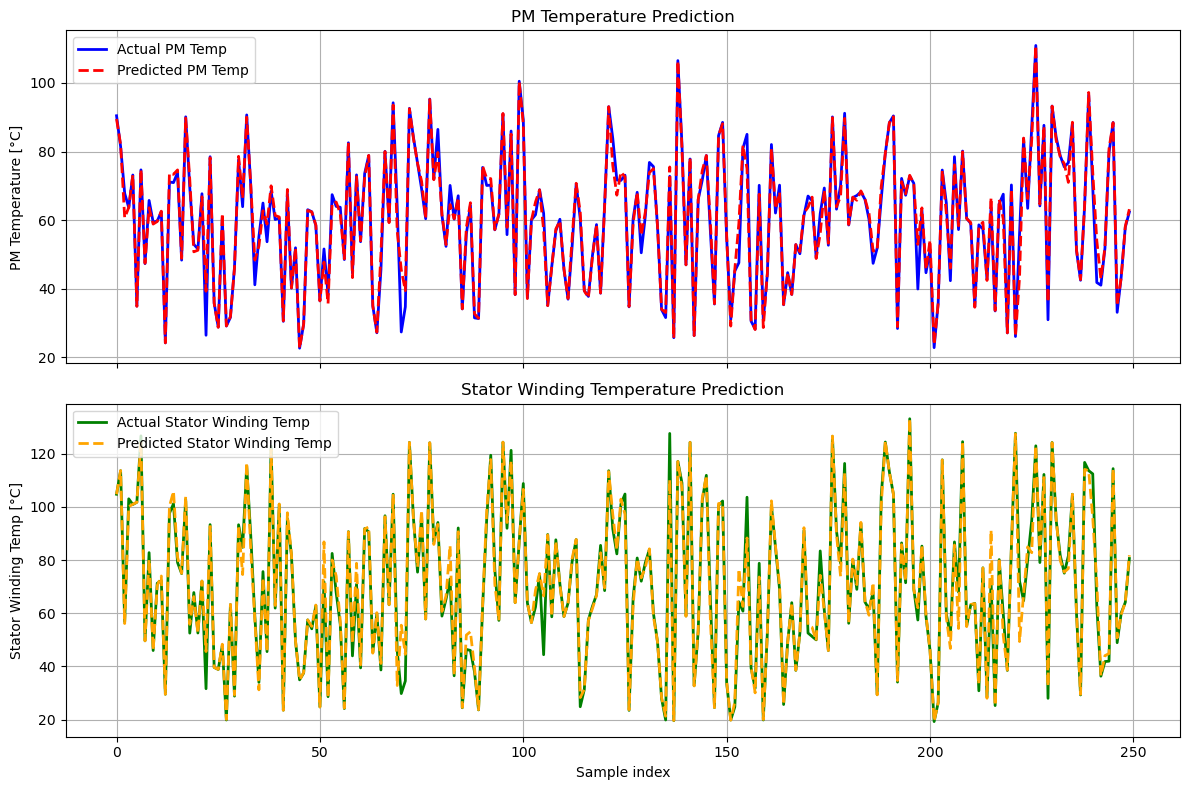

In [10]:
# Load the saved model
rf_loaded = joblib.load("rf_motor_temp_model.pkl")

# Predict with the loaded model
y_pred = rf_loaded.predict(X_test)

# Metrics
r2_pm_rf = r2_score(y_test['pm'], y_pred[:,0])
rmse_pm_rf = np.sqrt(mean_squared_error(y_test['pm'], y_pred[:,0]))

r2_stator_rf = r2_score(y_test['stator_winding'], y_pred[:,1])
rmse_stator_rf = np.sqrt(mean_squared_error(y_test['stator_winding'], y_pred[:,1]))

print(f"Random Forest PM R²: {r2_pm_rf:.3f}, RMSE: {rmse_pm_rf:.2f}")
print(f"Random Forest Stator Winding R²: {r2_stator_rf:.3f}, RMSE: {rmse_stator_rf:.2f}")

# Use a subset for readability if the dataset is large
n_samples = 250  
y_true = y_test.values[:n_samples]
y_pred = rf_loaded.predict(X_test.values[:n_samples])

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,8), sharex=True)

# PM Temperature
axes[0].plot(y_true[:,0], label="Actual PM Temp", color="blue", lw=2)
axes[0].plot(y_pred[:,0], label="Predicted PM Temp", color="red", lw=2, linestyle="--")
axes[0].set_ylabel("PM Temperature [°C]")
axes[0].set_title("PM Temperature Prediction")
axes[0].legend()
axes[0].grid(True)

# Stator Winding Temperature
axes[1].plot(y_true[:,1], label="Actual Stator Winding Temp", color="green", lw=2)
axes[1].plot(y_pred[:,1], label="Predicted Stator Winding Temp", color="orange", lw=2, linestyle="--")
axes[1].set_xlabel("Sample index")
axes[1].set_ylabel("Stator Winding Temp [°C]")
axes[1].set_title("Stator Winding Temperature Prediction")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In the first iteration of model development, no validation set was included; the model was trained and evaluated using only a training/test split. While the initial results were promising, omitting validation can mask overfitting and reduce confidence in the model’s generalization to slightly different operating conditions. Introducing a dedicated validation set ensures that hyperparameters are tuned safely, model architectures are selected robustly, and potential domain shifts are detected early. For more detailed discussion on the importance of validation, refer to https://young-wombat-ba9.notion.site/Validation-Phase-in-Physical-Value-Predictor-2905c07cd00380d8b8dbf4f069d8f1aa?source=copy_link.

| Metric      | Without Validation | Validation Set | Test (Predictor) |
| ----------- | ------------------ | -------------- | ---------------- |
| PM R²       | 0.974              | 0.973          | 0.973            |
| PM RMSE     | 3.06               | 3.13           | 3.12             |
| Stator R²   | 0.966              | 0.965          | 0.964            |
| Stator RMSE | 5.31               | 5.35           | 5.40             |


The Random Forest regression provides a working solution for temperature prediction, as it captures the overall trend of the data with good accuracy. However, sharp peaks and transient thermal dynamics are not always well reproduced, which could be critical in real-world applications where exceeding safe temperature thresholds may cause damage. Increasing the number of estimators or tree depth could potentially improve accuracy, but care must be taken to avoid overfitting.

### Gradient boosting

Following the Random Forest analysis, we explore Gradient Boosting regression as an alternative ensemble method for predicting motor temperatures. Unlike Random Forests, which build trees independently and average their predictions, Gradient Boosting builds trees sequentially, with each new tree trained to correct the errors of the previous ones. By combining multiple decision tree regressors or decision tree classifiers, gradient boosting can effectively capture complex relationships between features.

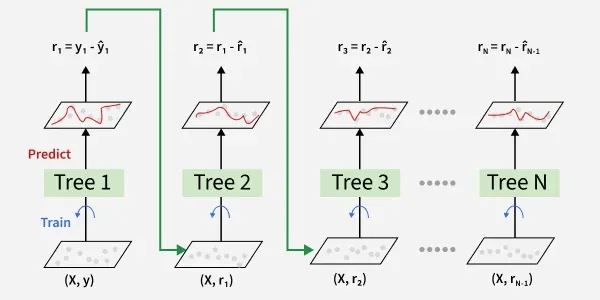

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import joblib
from xgboost import XGBRegressor

# Features 
X = ds[["torque", "motor_speed", "u_d", "u_q", "i_d", "i_q", "coolant", "ambient"]]

# Target
y = ds[['pm', 'stator_winding']]

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.125, random_state=42)

X_train_small = X_train.iloc[::10]
y_train_small = y_train.iloc[::10]

# Define XBG regressor
xgb = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.2)

In [7]:
# Ask for confirmation before training
confirm = input("Are you sure you want to train the model? This may take a while! (y/n): ")

if confirm.lower() == "y":
    # Train the model
    xgb.fit(X_train_small, y_train_small)

    # Validate
    y_val_pred = xgb.predict(X_val)
    r2_pm_val = r2_score(y_val['pm'], y_val_pred[:,0])
    rmse_pm_val = np.sqrt(mean_squared_error(y_val['pm'], y_val_pred[:,0]))
    r2_stator_val = r2_score(y_val['stator_winding'], y_val_pred[:,1])
    rmse_stator_val = np.sqrt(mean_squared_error(y_val['stator_winding'], y_val_pred[:,1]))
    
    print(f"Validation PM R²: {r2_pm_val:.3f}, RMSE: {rmse_pm_val:.2f}")
    print(f"Validation Stator Winding R²: {r2_stator_val:.3f}, RMSE: {rmse_stator_val:.2f}")
    
    # Save the trained model
    joblib.dump(xgb, "xgb_motor_temp_model.pkl")
    
    print("Model trained and saved successfully!")
else:
    print("Training canceled.")

Are you sure you want to train the model? This may take a while! (y/n):  y


Validation PM R²: 0.971, RMSE: 3.23
Validation Stator Winding R²: 0.959, RMSE: 5.79
Model trained and saved successfully!


XBGRegressor PM R²: 0.971, RMSE: 3.22
XBGRegressor Stator Winding R²: 0.958, RMSE: 5.84


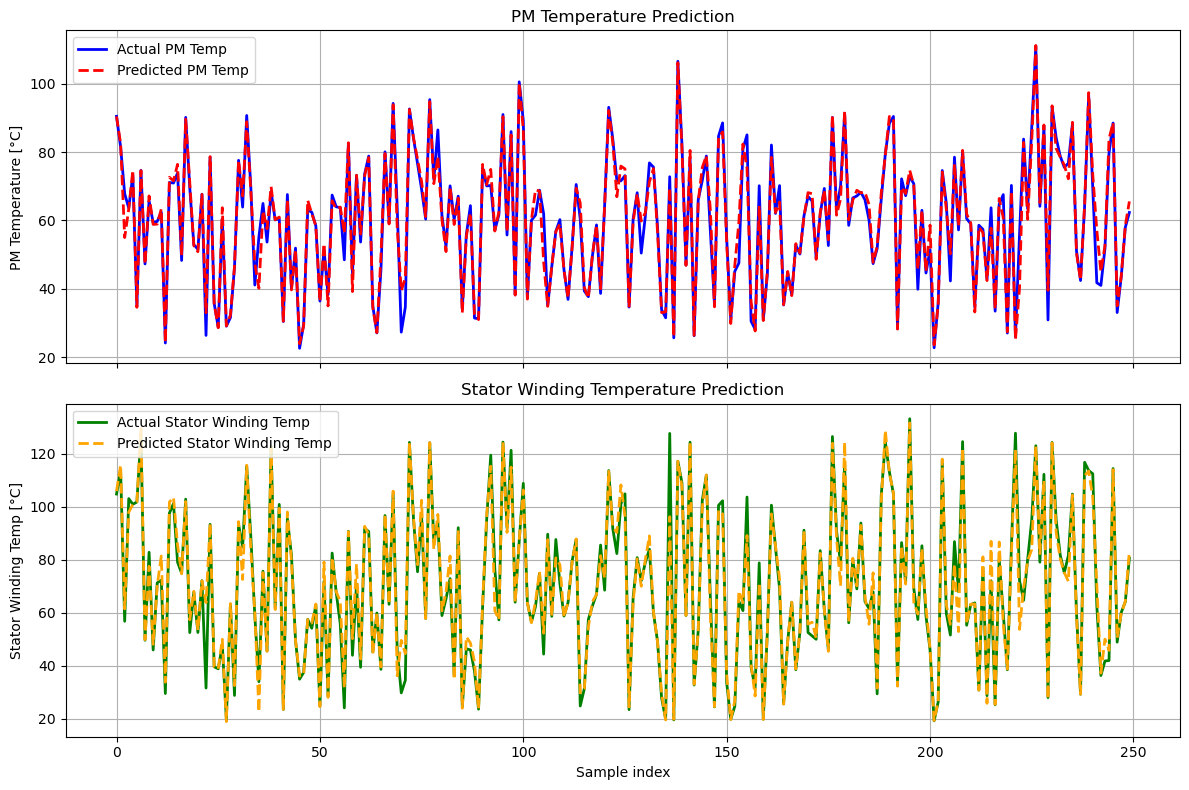

In [13]:
# Load the saved model
xgb_loaded = joblib.load("xgb_motor_temp_model.pkl")

# Predict with the loaded model
y_pred = xgb_loaded.predict(X_test)

# Metrics
r2_pm_gb = r2_score(y_test['pm'], y_pred[:,0])
rmse_pm_gb = np.sqrt(mean_squared_error(y_test['pm'], y_pred[:,0]))

r2_stator_gb = r2_score(y_test['stator_winding'], y_pred[:,1])
rmse_stator_gb = np.sqrt(mean_squared_error(y_test['stator_winding'], y_pred[:,1]))

print(f"XBGRegressor PM R²: {r2_pm_gb:.3f}, RMSE: {rmse_pm_gb:.2f}")
print(f"XBGRegressor Stator Winding R²: {r2_stator_gb:.3f}, RMSE: {rmse_stator_gb:.2f}")

# Use a subset for readability if the dataset is large
n_samples = 250  
y_true = y_test.values[:n_samples]
y_pred = xgb_loaded.predict(X_test.values[:n_samples])

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,8), sharex=True)

# PM Temperature
axes[0].plot(y_true[:,0], label="Actual PM Temp", color="blue", lw=2)
axes[0].plot(y_pred[:,0], label="Predicted PM Temp", color="red", lw=2, linestyle="--")
axes[0].set_ylabel("PM Temperature [°C]")
axes[0].set_title("PM Temperature Prediction")
axes[0].legend()
axes[0].grid(True)

# Stator Winding Temperature
axes[1].plot(y_true[:,1], label="Actual Stator Winding Temp", color="green", lw=2)
axes[1].plot(y_pred[:,1], label="Predicted Stator Winding Temp", color="orange", lw=2, linestyle="--")
axes[1].set_xlabel("Sample index")
axes[1].set_ylabel("Stator Winding Temp [°C]")
axes[1].set_title("Stator Winding Temperature Prediction")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

As previously explained why, also for the XGBRegressor model the results obtained without including a validation phase are reported.
| Dataset / Phase     | PM R² | PM RMSE | Stator Winding R² | Stator Winding RMSE |
| ------------------- | ----- | ------- | ----------------- | ------------------- |
| **No Validation**   | 0.973 | 3.11    | 0.961             | 5.63                |
| **Validation**      | 0.971 | 3.23    | 0.959             | 5.79                |
| **Simulation/Test** | 0.971 | 3.22    | 0.958             | 5.84                |


### Conclusion

This project successfully developed a data-driven predictor for motor temperatures, focusing on the permanent magnet and stator winding, using workbench test data as ground truth.

Both models perform very well in predicting motor temperatures, with R² values above 0.96 for both PM and stator winding temperatures. The differences between the models are minimal, with Random Forest slightly better for stator winding (R²: 0.966 vs 0.961) and PM (R²: 0.974 vs 0.973). RMSE values also confirm this small difference.

In [14]:
data = {
    "Model": ["Random Forest", "Gradient Boosting",  "Random Forest", "Gradient Boosting"],
    "Target": ["PM Temperature",  "PM Temperature", "Stator Winding", "Stator Winding"],
    "R²": [r2_pm_rf, r2_pm_gb, r2_stator_rf, r2_stator_gb],
    "RMSE": [rmse_pm_rf, rmse_pm_gb, rmse_stator_rf, rmse_stator_gb]
}

df_results = pd.DataFrame(data)

# Display table
print(df_results)

               Model          Target        R²      RMSE
0      Random Forest  PM Temperature  0.973013  3.122306
1  Gradient Boosting  PM Temperature  0.971274  3.221338
2      Random Forest  Stator Winding  0.964472  5.403543
3  Gradient Boosting  Stator Winding  0.958435  5.844623


Despite the overall high accuracy of the models, some short-term transient peaks in temperatures were not perfectly captured, which could be critical in real-world operation. This limitation arises because the models do not explicitly account for thermal inertia or time-dependent effects, meaning sudden spikes may be underestimated. Additionally, there is a risk of overfitting if trees are too deep or too many estimators are used without proper cross-validation, potentially reducing the model’s generalization to unseen operating conditions.

## Thermal Neural Network (TNN): an hybrid approach

As proposed in the literature, the most effective approach for thermal analysis problems is the use of hybrid models that combine physical equations with machine learning techniques. In this context, the model is referred to as a Thermal Neural Network (TNN). A detailed theoretical and methodological analysis of TNNs can be found in (https://young-wombat-ba9.notion.site/Thermal-Neural-Network-2935c07cd00380f38c62f01e1e3dc255?source=copy_link)

Given the complexity of this approach the implementation of the TNN in this work will follow an object-oriented programming (OOP) structure in Python. Therefore, the report will include only a pseudocode description, the obtained results, and a discussion of the methodology, analysis, and conclusions derived from the model.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import Parameter as TorchParam
from torch import Tensor
from typing import List, Tuple

In [9]:
data = pd.read_csv(.../data/measures_v2.csv)
target_cols = ["pm", "stator_yoke", "stator_tooth", "stator_winding"]

temperature_cols = target_cols + ["ambient", "coolant"]
test_profiles = [60, 62, 74]
train_profiles = [p for p in data.profile_id.unique() if p not in test_profiles]
profile_sizes = data.groupby("profile_id").agg("size")

# normalize
non_temperature_cols = [c for c in data if c not in temperature_cols + ["profile_id"]]
data.loc[:, temperature_cols] /= 200  # deg C
data.loc[:, non_temperature_cols] /= data.loc[:, non_temperature_cols].abs().max(axis=0)

# extra feats (FE)
if {"i_d", "i_q", "u_d", "u_q"}.issubset(set(data.columns.tolist())):
    extra_feats = {
        "i_s": lambda x: np.sqrt((x["i_d"] ** 2 + x["i_q"] ** 2)),
        "u_s": lambda x: np.sqrt((x["u_d"] ** 2 + x["u_q"] ** 2)),
    }
data = data.assign(**extra_feats)
input_cols = [c for c in data.columns if c not in target_cols]
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# overwrite. We recommend CPU over GPU here, as that runs faster with pytorch on this data set
device = torch.device("cpu")

NameError: name 'data' is not defined

In [ ]:
# Rearrange features
input_cols = [c for c in data.columns if c not in target_cols + ["profile_id"]]
data = data.loc[:, input_cols + ["profile_id"] + target_cols]


def generate_tensor(profiles_list):
    """Returns profiles of the data set in a coherent 3D tensor with
    time-major shape (T, B, F) where
    T : Maximum profile length
    B : Batch size = Amount of profiles
    F : Amount of input features.

    Also returns a likewise-shaped sample_weights tensor, which zeros out post-padded zeros for use
    in the cost function (i.e., it acts as masking tensor)"""
    tensor = np.full(
        (profile_sizes[profiles_list].max(), len(profiles_list), data.shape[1] - 1),
        np.nan,
    )
    for i, (pid, df) in enumerate(
        data.loc[data.profile_id.isin(profiles_list), :].groupby("profile_id")
    ):
        assert pid in profiles_list, f"PID is not in {profiles_list}!"
        tensor[: len(df), i, :] = df.drop(columns="profile_id").to_numpy()
    sample_weights = 1 - np.isnan(tensor[:, :, 0])
    tensor = np.nan_to_num(tensor).astype(np.float32)
    tensor = torch.from_numpy(tensor).to(device)
    sample_weights = torch.from_numpy(sample_weights).to(device)
    return tensor, sample_weights


train_tensor, train_sample_weights = generate_tensor(train_profiles)
test_tensor, test_sample_weights = generate_tensor(test_profiles)

In [ ]:
from TNN import (
    DiffEqLayer,
    TNNCell
)

Training

In [ ]:
model = torch.jit.script(DiffEqLayer(TNNCell).to(device))
loss_func = nn.MSELoss(reduction="none")
opt = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 100
tbptt_size = 512

n_batches = np.ceil(train_tensor.shape[0] / tbptt_size).astype(int)
with tqdm(desc="Training", total=n_epochs) as pbar:
    for epoch in range(n_epochs):
        # first state is ground truth temperature data
        hidden = train_tensor[0, :, -len(target_cols) :]

        # propagate batch-wise through data set
        for i in range(n_batches):
            model.zero_grad()
            output, hidden = model(
                train_tensor[
                    i * tbptt_size : (i + 1) * tbptt_size, :, : len(input_cols)
                ],
                hidden.detach(),
            )
            loss = loss_func(
                output,
                train_tensor[
                    i * tbptt_size : (i + 1) * tbptt_size, :, -len(target_cols) :
                ],
            )
            # sample_weighting
            loss = (
                (
                    loss
                    * train_sample_weights[
                        i * tbptt_size : (i + 1) * tbptt_size, :, None
                    ]
                    / train_sample_weights[
                        i * tbptt_size : (i + 1) * tbptt_size, :
                    ].sum()
                )
                .sum()
                .mean()
            )
            loss.backward()
            opt.step()

        # reduce learning rate
        if epoch == 75:
            for group in opt.param_groups:
                group["lr"] *= 0.5
        pbar.update()
        pbar.set_postfix_str(f"loss: {loss.item():.2e}")

testing

In [ ]:
# model saving and loading
mdl_path = Path.cwd() / 'data' / 'models'
mdl_path.mkdir(exist_ok=True, parents=True)
mdl_file_path = mdl_path / 'tnn_jit_torch.pt'

model.save(mdl_file_path)  # save
model = torch.jit.load(mdl_file_path)  # load
model.eval()

In [ ]:
# evaluate against test set
with torch.no_grad():
    pred, hidden = model(
        test_tensor[:, :, : len(input_cols)], test_tensor[0, :, -len(target_cols) :]
    )
    pred = pred.cpu().numpy() * 200  # denormalize

Visualize

In [ ]:
fig, axes = plt.subplots(len(test_profiles), len(target_cols), figsize=(20, 10))
for i, (pid, y_test) in enumerate(
    data.loc[data.profile_id.isin(test_profiles), target_cols + ["profile_id"]].groupby(
        "profile_id"
    )
):
    y_test *= 200
    profile_pred = pred[: len(y_test), i, :]
    for j, col in enumerate(target_cols):
        ax = axes[i, j]
        ax.plot(
            y_test.loc[:, col].reset_index(drop=True),
            color="tab:green",
            label="Ground truth",
        )
        ax.plot(profile_pred[:, j], color="tab:blue", label="Prediction")
        ax.text(
            x=0.5,
            y=0.8,
            s=f"MSE: {((profile_pred[:, j] - y_test.loc[:, col])**2).sum() / len(profile_pred):.3f} K²\nmax.abs.:{(profile_pred[:, j]-y_test.loc[:, col]).abs().max():.1f} K",
            transform=ax.transAxes,
        )
        if j == 0:
            ax.set_ylabel(f"Profile {pid}\n Temp. in °C")
            if i == 0:
                ax.legend()
        if i == len(test_profiles) - 1:
            ax.set_xlabel(f"Iters")
        elif i == 0:
            ax.set_title(col)